## Setup 

In [1]:
## imports
import qiskit
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
#import qiskit.providers.models as mods
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator, FormatStrFormatter
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import seaborn as sns
import pandas as pd
from pprint import pprint

#import matplotlib as mpl
# matplotlib.rc('font',family='arial')

qiskit.__version__

'0.19.2'

In [2]:
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
## setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
# mumbai = provider.get_backend('ibmq_mumbai')
#melbourne = provider.get_backend('ibmq_melbourne')
aer = Aer.get_backend('aer_simulator')
qsm_simulator = Aer.get_backend('qasm_simulator')
stv_simulator = Aer.get_backend('statevector_simulator')

#device = provider.get_backend('ibmq_16_melbourne') #ibmq_16_melbourne ibmqx2
#noise_model = NoiseModel.from_backend(device)
#pprint(vars(provider.backends))

## Circuit

In [3]:
## helper functions ~
def wmatrix(attractors):
    """ Pass the attractors to be stored as a list 'attractors' 
        NB~ attractors should be column vectors """   
    l = len(attractors[0])
    wm = np.zeros((l, l))

    for atractr in attractors:
        wm += np.outer(atractr, atractr)
    return wm

def update(qc, qubit, cntrl_reg, phi, bias):
    """ Update 'qubit' of the circuit 'qc' 
    using 'cntrl_reg': the control qubits """
    cntrls = len(cntrl_reg)
    for cntrl in range(cntrls):
        qc.cry((phi[cntrl]), cntrl_reg[cntrl], qubit)
    qc.ry(bias, qubit)
    #qc.barrier()

def plot_attractor(attractors,n):
    plt.figure(figsize=(12,10))
    for a in range(len(attractors)):
        plt.subplot(3, 4, a+1)
        plt.title("Config "+ str(a)+ ": ")
        sns.heatmap(attractors[a].reshape((n,n)), xticklabels=False, yticklabels=False, cbar=False)


## main driver code ~
def experiment( x_0, attractors, N, q_update):
    
    #classical prep ~
    l = len(attractors[0])
    wm = wmatrix(attractors)
    
    #quantum prep ~
    qnet = QuantumRegister(l, name='qnet')
    qa = AncillaRegister(1, name='ancilla')
    #creg = ClassicalRegister(l, name='creg')
    qc = QuantumCircuit(qnet, qa)
    for q in range(l+1):
        qc.reset(q)
    for q in range(l):
        if(x_0[q] == 1):
            qc.x(q)
        elif(x_0[q] == 0):
            qc.h(q)
    qc.barrier()

    #update sub-routine ~~
    for qu in q_update:
        qc.reset(qa)
        controls = [cntrl for cntrl in range(l) if l!=qu ]
        gamma = math.pi/( 4*wm.max()*(l-1) ) #n-1 is because we need size of control layer
        beta = (math.pi/4)+gamma*(-sum(wm[qu][controls]))
        update(qc, qa, controls,4*gamma*wm[qu][controls], 2*beta )
        qc.swap(qa, qu)
        
    #measurements ~~
    for q in range(l):
        qc.measure(q, l-q-1)
    
    ##execute ~~
    job = execute(qc, backend= aer, shots= 1200)
    counts = job.result().get_counts()

    reg_count = np.zeros(l)
    for key,value in counts.items():
        for q in range(l):
             if key[q] == '1':
                reg_count[q] += value
    reg_count = np.flip(reg_count/sum(counts.values()))
    reg_count_classical = np.array([0 if reg_count[i]<=0.5 else 1 for i in range(len(reg_count)) ])


    return reg_count, reg_count_classical


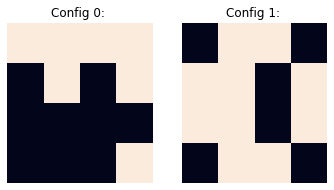

In [4]:
n = 4  
N = n*n
attractors = [np.random.choice([1, -1], size=N ) for i in range(2) ]
plot_attractor(attractors, n)

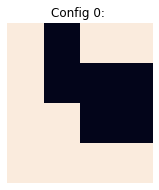

In [5]:
x_0 = np.random.choice([-1,1], size= N)
plot_attractor([x_0], n)

In [6]:
q_update= np.random.choice(range(16), size= 16)

In [7]:
#classical prep ~
l = len(attractors[0])
wm = wmatrix(attractors)

#quantum prep ~
qnet = QuantumRegister(l, name='qnet')
qa = AncillaRegister(1, name='ancilla')
clreg = ClassicalRegister(l, name='creg')
qc = QuantumCircuit(qnet, qa, clreg)

for q in range(l+1):
    qc.reset(q)
for q in range(l):
    if(x_0[q] == 1):
        qc.x(q)
    elif(x_0[q] == 0):
        qc.h(q)
qc.barrier()

#update sub-routine ~~
for qu in q_update:
    qc.reset(qa)
    controls = [cntrl for cntrl in range(l) if cntrl != qu ]
    gamma = math.pi/( 4*wm.max()*(l-1) + 0.00001) #l-1 is because we need size of control layer
    beta = (math.pi/4)+gamma*(-sum(wm[qu][controls]))
    update(qc, qa, controls,4*gamma*wm[qu][controls], 2*beta )
    qc.swap(qa, qu)
    qc.barrier()
    qc.measure(qnet, clreg)    


#measurements ~~
# qc.measure(qnet, clreg)

##execute ~~
job = execute(qc, backend= aer, shots= 1200)
counts = job.result().get_counts()

reg_count = np.zeros(l)
for key,value in counts.items():
    for q in range(l):
            if key[q] == '1':
                reg_count[q] += value

reg_count = np.flip(reg_count/sum(counts.values()))
reg_count_classical = np.array([0 if reg_count[i]<=0.5 else 1 for i in range(len(reg_count)) ])

In [16]:
# qc.draw(output='mpl')

<AxesSubplot:>

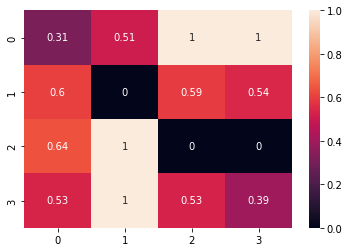

In [8]:
sns.heatmap(reg_count.reshape(n,n), annot= True )

<AxesSubplot:>

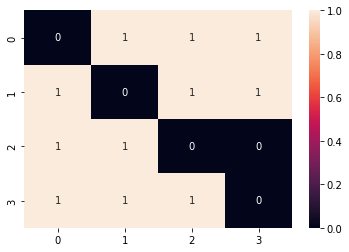

In [9]:
sns.heatmap(reg_count_classical.reshape(n,n), annot= True )

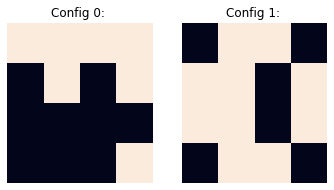

In [10]:
plot_attractor(attractors, n)

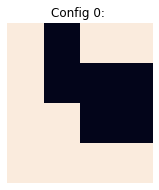

In [11]:
plot_attractor([x_0], n)